In [1]:
import os
import cv2
import glob
import gdcm
import pydicom
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from joblib import Parallel, delayed
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [2]:
TRAIN_PATH = "./rsna2023atd_files/train_images/"
TEST_PATH = "./rsna2023atd_files/test_images/"

In [3]:
df_train_dicom = pd.read_parquet("./rsna2023atd_files/train_dicom_tags.parquet")
df_train_dicom["PatientID"] = df_train_dicom["PatientID"].astype(str)
df_train_dicom["serie"] = df_train_dicom["SeriesInstanceUID"].apply(lambda x: x.split(".")[-1])
df_train_dicom = df_train_dicom.set_index(["PatientID", "serie"]).sort_index()

df_test_dicom = pd.read_parquet("./rsna2023atd_files/train_dicom_tags.parquet")
df_test_dicom["PatientID"] = df_test_dicom["PatientID"].astype(str)
df_test_dicom["serie"] = df_test_dicom["SeriesInstanceUID"].apply(lambda x: x.split(".")[-1])
df_test_dicom = df_test_dicom.set_index(["PatientID", "serie"]).sort_index()

In [4]:
def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:

    '''
    https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    https://www.kaggle.com/code/theoviel/get-started-quicker-dicom-png-conversion
    https://www.kaggle.com/code/alenic/dataset-size-reduction-400gb-to-7-5gb
    '''

    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift

    # transform to hounsfield units
    intercept = float(dcm.RescaleIntercept)
    slope = float(dcm.RescaleSlope)
    pixel_array = (pixel_array * slope) + intercept

    # windowing
    center = int(dcm.WindowCenter)
    width = int(dcm.WindowWidth)
    low = center - width / 2
    high = center + width / 2    
    pixel_array = np.clip(pixel_array, low, high)

    return pixel_array




  0%|          | 0/3147 [00:00<?, ?it/s]





















































100%|██████████| 1044/1044 [00:05<00:00, 188.88it/s]


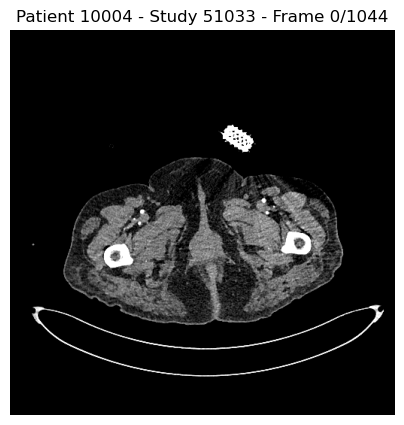

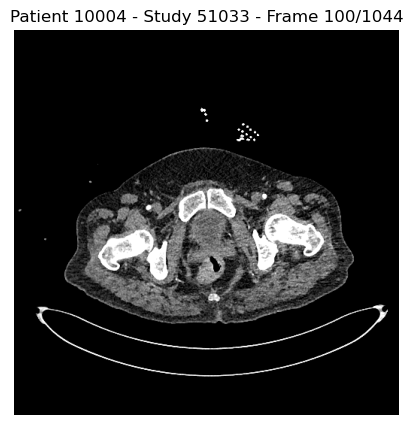

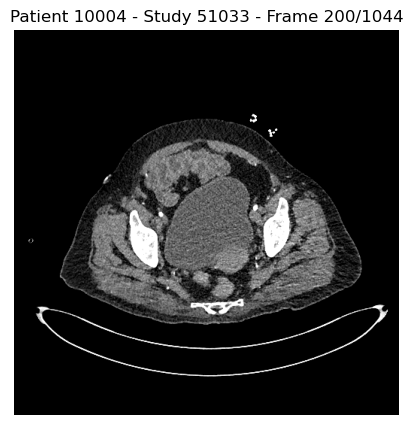

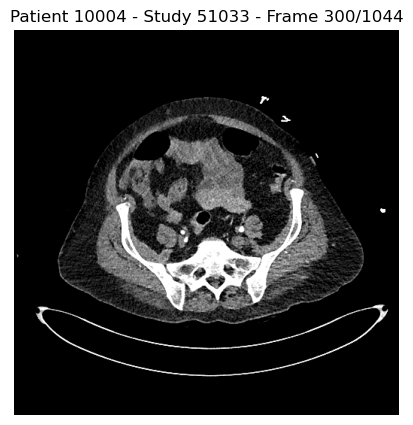

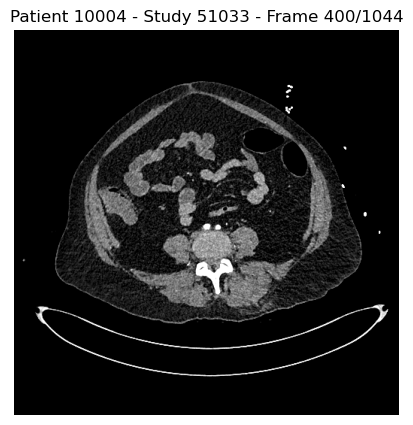

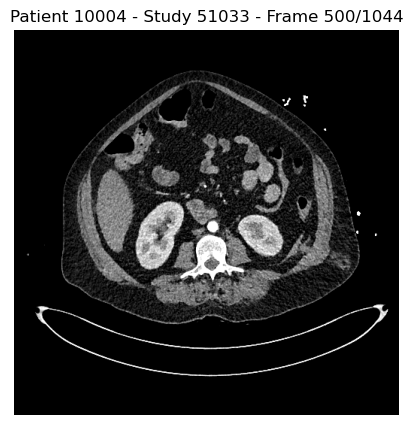

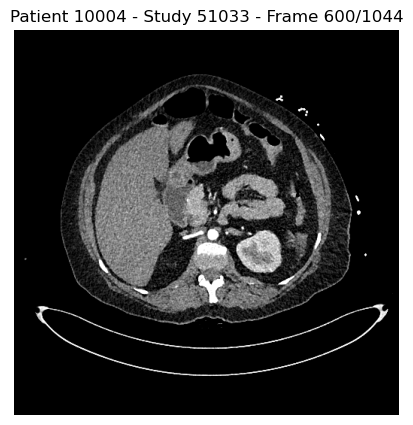

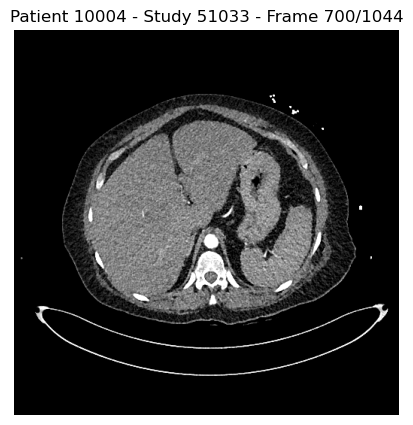

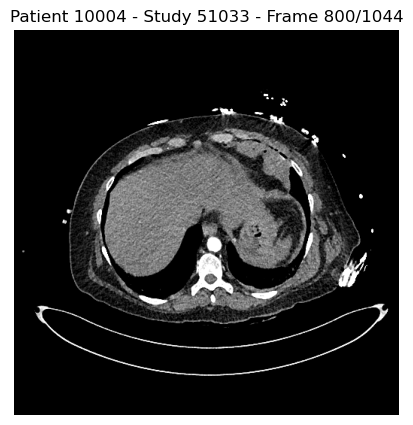

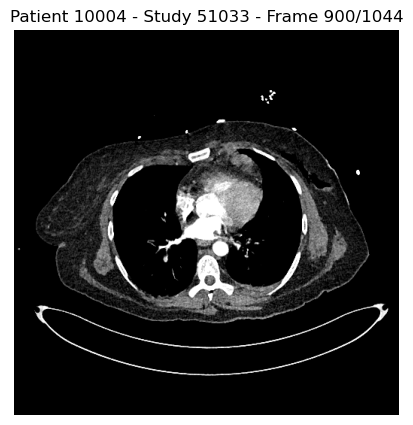

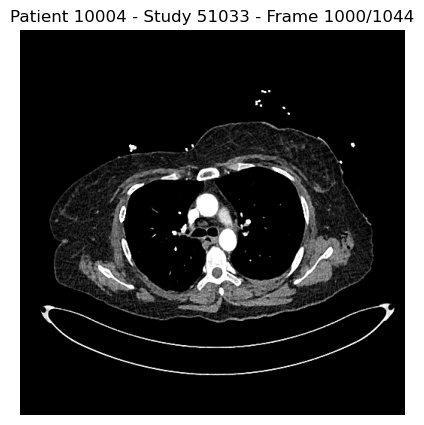

  0%|          | 0/3147 [00:06<?, ?it/s]


In [5]:

thickness = 5

for patient in tqdm(sorted(os.listdir(TRAIN_PATH))):
    
    
    for study in tqdm(os.listdir(TRAIN_PATH + patient)):
        
        '''
        slice_thickness = df_dicom.loc[(patient, study), "SliceThickness"].mean()
        step = round(thickness/slice_thickness)
        '''
        
        imgs = {}
        
        for f in tqdm(sorted(glob.glob(TRAIN_PATH + f"{patient}/{study}/*.dcm"))):
            
            dicom = pydicom.dcmread(f)
            
            # retrieve the order of frames
            pos_z = dicom[(0x20, 0x32)].value[-1]  

            img = standardize_pixel_array(dicom)

            # normalization
            img = (img - img.min()) / (img.max() - img.min())

            if dicom.PhotometricInterpretation == "MONOCHROME1":
                img = 1 - img

            imgs[pos_z] = img


        for i, k in enumerate(sorted(imgs.keys())):
            
            img = imgs[k]

            if not (i % 100):
                plt.figure(figsize=(5, 5))
                plt.imshow(img, cmap="gray")
                plt.title(f"Patient {patient} - Study {study} - Frame {i}/{len(imgs)}")
                plt.axis(False)
                plt.show()
    
        break
    break

In [6]:
def process(patient, save_folder="", data_path=""):
    

    for study in sorted(os.listdir(data_path + patient)):
        
        '''
        thickness = 5
        slice_thickness = df_train_dicom.loc[(patient, study), "SliceThickness"].mean()
        step = round(thickness/slice_thickness)
        '''

        imgs = {}

        for f in sorted(glob.glob(data_path + f"{patient}/{study}/*.dcm")):

            dicom = pydicom.dcmread(f)

            pos_z = dicom[(0x20, 0x32)].value[-1]
        
            img = standardize_pixel_array(dicom)
            img = (img - img.min()) / (img.max() - img.min() + 1e-6)

            if dicom.PhotometricInterpretation == "MONOCHROME1":
                img = 1 - img

            imgs[pos_z] = img


    for i, k in enumerate(sorted(imgs.keys())):

        img = imgs[k]

        cv2.imwrite(save_folder + f"{patient}_{study}_{i}.png", (img * 255).astype(np.uint8))

    return None

In [8]:
patients = os.listdir(TRAIN_PATH)

for patient in tqdm(patients):
    process(patient, save_folder="./train_png/", data_path=TRAIN_PATH)

  7%|▋         | 211/3147 [10:04<1:50:56,  2.27s/it]